# CW2: Natural Language Processing: Classification of News Articles
This coursework extends Lab 8, using the content of news articles to classify them into one of the 4 following categories: `World, Sports, Business, Sci/Tech`.

The original data source is http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html. You do not need to download the data from those websites, it has been made available on GCU learn in the compressed file 'news_dataset.zip', you simply need to download and extract it. You'll get files *train.csv* and *test.csv*. Place them in the same folder as this notebook (or change the path in `pd.read_csv()` accordingly).

Import Conda environmet `lab8_NLP_news.yml`.

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing
import re
import nltk
import spacy
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Machine learning
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, classification_report)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

# Deep learning
import tensorflow as tf
from tensorflow.keras.layers import (
    TextVectorization,
    Embedding,
    LSTM,
    Bidirectional,
    Dense,
    Embedding,
    Input,
    Conv1D,
    GlobalMaxPool1D
)
from tensorflow.keras.models import Sequential

# Settings
sns.set_style("whitegrid")

# Spacy settings
!python -m spacy download en_core_web_sm
NER = spacy.load('en_core_web_sm')

## Remove 'no' and 'not' from SpaCy's stop words list
deselect_stop_words = ['no', 'not']
for w in deselect_stop_words:
    NER.vocab[w].is_stop = False

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2023-12-29 15:40:28.947627: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 15:40:28.947695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 15:40:28.949147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 15:40:30.241780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# 1. Data preparation
Import data.

In [113]:
# Importing the dataset. As done in lab 4, you usually have a look at the data. Here we simply show the first 5 rows
train_data = pd.read_csv("/content/drive/MyDrive/GCU/ai_ml/coursework/coursework_2/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/GCU/ai_ml/coursework/coursework_2/test.csv")
train_data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [114]:
# Number of classes
print("Training data class indexes")
print(train_data['Class Index'].value_counts())
print("\nTest data class indexes")
print(test_data["Class Index"].value_counts())

Training data class indexes
3    30000
4    30000
2    30000
1    30000
Name: Class Index, dtype: int64

Test data class indexes
3    1900
4    1900
2    1900
1    1900
Name: Class Index, dtype: int64


Change labels from 1-4 to 0-3

In [115]:
# substract 1 from the target variable for both, train and test data
train_data["Class Index"] = train_data["Class Index"] - 1
test_data["Class Index"] = test_data["Class Index"] - 1
label_names = ["World", "Sports", "Business", "Sci/Tech"] # 0 is "World", 1 is "Sports", ...

## Preprocessing

Lowercase descriptions and clean up non-letter characters.

**TODO 1**: Remove the occurences of "http" "href", "https" and "www". Also, remove the names of the news agencies (Reuters, AP, ...) from the datasets.

In [116]:
def create_word_cloud(article):
  """
  Input a news article and generate a word cloud of the 1000 most popular words
  """
  wordcloud = WordCloud(
      max_words=1000,
      background_color="white"
      ).generate(article)

  plt.figure(figsize=(10, 8), facecolor=None)
  plt.axis("off")
  plt.imshow(wordcloud)

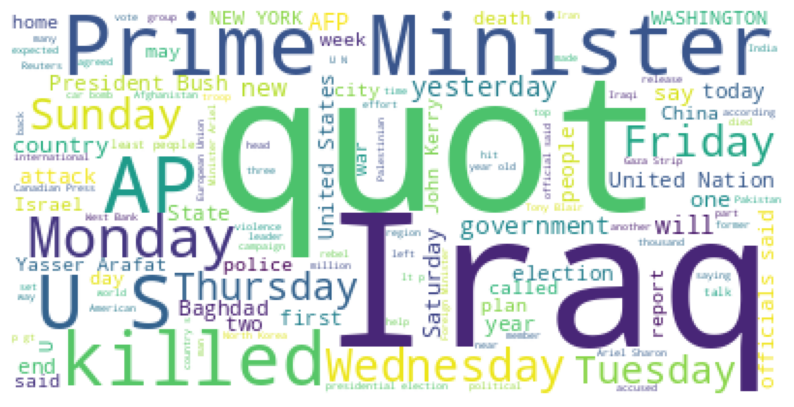

In [117]:
sample_text = " ".join(train_data[train_data["Class Index"] == 0]["Description"])

create_word_cloud(sample_text)

We can see that within Class Index 0 there are several pieces of text that need to be cleaned such as html tags, news agencies, names of people amongst others.

In [118]:
# Function to preprocess the data
def preprocess_text(string):
    # TODO 1: REMOVE http (html, ...) and news agencies names (Reuters, AP, ...)


    string = string.lower()
    words_to_remove = ["ap", "reuters", "usatoday com", "techweb",
                       "space com", "maccentral", "cnn", "afp",
                       "forbes com", "said"]
    for word in words_to_remove:
        string = string.replace(word, " ")

    string = string.replace("'", " ")
    string = string.replace("\\", " ")
    string = re.sub(r"[^a-zA-Z]", " ", string) # removes all non-chars
    string = re.sub(r"\b\w\b", " ", string) # removes single chars
    string = re.sub(r"\s+", " ", string) # removes consecutive white spaces

    return string

# Removing tags
def remove_tags(text):
    """
        Remove html or any other tags from a piece of string
        Example:
            <p> -> ""
    """
    clean_text = re.compile("<.*?>")
    text = re.sub(r'https?\S+\.com?\S*', " ", text)
    text = re.sub(r'http?\S+\.com?\S*', " ", text)
    text = re.sub(r'www?\S+\.com?\S*', " ", text)
    text = re.sub(r"href\S+", "", text)
    re.sub(r"\b(lt|gt)\b", "", text)
    text = text.replace("quot", "")
    text = text.replace("href", "")

    return re.sub(clean_text, " ", text)

# Removing entity names
def remove_named_entities(text):
    """
        Removes all stated Named Entities based of Spacy's NER.
    """
    doc = NER(text)
    # for word in doc.ents:
    #     print(word.text,word.label_)

    filtered_text = []
    for token in doc:
        if token.ent_type_ not in ("ORG", "PERSON", "GPE", "TIME",
                                   "DATE", "ORDINAL", "PERCENT"):
            filtered_text.append(token.text)

    return " ".join(filtered_text)

In [119]:
# Testing functions
desc = train_data["Description"][0]

print("Original text: ")
print(desc)

print("--"*20)
print("Intial Preprocess Function: ")
print(preprocess_text(desc))

print("--"*20)
print("Removing web tags: ")
print(remove_tags(desc))

print("--"*20)
print("Removing entity names: ")
print(remove_named_entities(desc))


Original text: 
Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
----------------------------------------
Intial Preprocess Function: 
 short sellers wall street dwindling band of ultra cynics are seeing green again 
----------------------------------------
Removing web tags: 
Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
----------------------------------------
Removing entity names: 
- Short - sellers , Wall Street 's dwindling\band of ultra - cynics , are seeing green again .


In [ ]:
train_data["Description"] = train_data["Description"].apply(remove_tags)
test_data["Description"] = test_data["Description"].apply(remove_tags)

train_data["Description"] = train_data["Description"].apply(preprocess_text)
test_data["Description"] = test_data["Description"].apply(preprocess_text)

train_data["Description"] = train_data["Description"].apply(remove_named_entities)
test_data["Description"] = test_data["Description"].apply(remove_named_entities)

sample_text = " ".join(train_data[train_data["Class Index"] == 2]["Description"])
print("Output after preprocessing:\n")
create_word_cloud(sample_text)

Convert dataframes to lists (needed for further functions).

In [ ]:
train_data_list = train_data["Description"].tolist()
test_data_list = test_data["Description"].tolist()
train_labels_list = train_data["Class Index"].tolist()
test_labels_list = test_data["Class Index"].tolist()

Create validation set (taking out 20% of test set)

In [ ]:
(train_data_list, validation_data_list,
 train_labels_list, validation_labels_list) = train_test_split(train_data_list,
                                                               train_labels_list,
                                                               test_size=0.2,
                                                               stratify=train_labels_list)

### Removing Stop Words
Remove stopwords from the *stopword* corpus.

In [ ]:
nltk.download("stopwords")
def remove_stopwords(data_list):
    stopword_list = nltk.corpus.stopwords.words("english")
    for i in range(len(data_list)):
        data_list[i] = " ".join(
            [word for word in data_list[i].split() if word not in (stopword_list)]
        )
    return data_list

In [ ]:
train_data_list = remove_stopwords(train_data_list)
validation_data_list = remove_stopwords(validation_data_list)
test_data_list = remove_stopwords(test_data_list)

### TODO 2: Lemmatization
Use **Stemming** or **Lemmatization** to grammatical word variations.

In [ ]:
# TODO 2: YOUR CODE HERE
def lemmatize_words(text_list):
    """
        This function gets the root name for words
        Example:
            Players -> Player
    """
    lemma = WordNetLemmatizer()
    lemmatized_list = []

    for text in text_list:
        tokens = word_tokenize(text)
        lemmatized_tokens = [lemma.lemmatize(token) for token in tokens]
        lemmatized_sentence = " ".join(lemmatized_tokens)
        lemmatized_list.append(lemmatized_sentence)

    return lemmatized_list

In the above function we decided to split the sentence into individual words so that we can tokenize them, this is to ensure that we don't try lemmatize the whole sentence but just the individual words.

In [ ]:
sample_sentence = train_data_list[0]

print(f"Sample sentence: \n{sample_sentence}")

print("--"*20)
lemmatize_words([sample_sentence])

In [ ]:
train_data_list = lemmatize_words(train_data_list)
validation_data_list = lemmatize_words(validation_data_list)
test_data_list = lemmatize_words(test_data_list)

## 2. Recurrent Neural Network classifier with Keras and Tensorflow

One-hot encode the labels (0 -> 0001, 1 -> 0010, ...) to match NN classifier head output.

In [ ]:
# the labels are of value 0, 1, 2, 3. We need to convert them to one-hot encoded vectors
train_labels = tensorflow.keras.utils.to_categorical(np.array(train_labels_list), num_classes=4)
validation_labels = tensorflow.keras.utils.to_categorical(np.array(validation_labels_list), num_classes=4)
test_labels = tensorflow.keras.utils.to_categorical(np.array(test_labels_list), num_classes=4)
print(train_labels.shape)

First we use the TextVectorization layer to convert the text to a sequence of integers. You can read about how this works  [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).


In [ ]:
# this will create a vocabulary of the top 2500 words and then convert the text to a sequence of numbers
vocab_size = 2500 # how many of the most frequent words to keep
sequence_length = 30 # how many words we use to represent a description
vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=sequence_length)
# fit the vectorizer on the training data (find the most common words and assign values to them)
vectorizer.adapt(train_data_list)
# show the selected words
print(vectorizer.get_vocabulary())

In [ ]:
# vectorize the training data (replace words by their associated values)
train_data_vectorized = vectorizer(train_data_list)
# vectorize the validation data
validation_data_vectorized = vectorizer(validation_data_list)
# vectorize the test data
test_data_vectorized = vectorizer(test_data_list)
# this shape shows that we have our 96000 training examples, each as a vector of 30 integers
print(train_data_vectorized.shape)

In [ ]:
# see how a vectorized news description looks like
print(train_data_vectorized[1])

We then build a RNN.

We use an *Embedding layer* to convert the integer sequences to embeddings. You can read about how this works [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

The Bidirectional layer takes the input and passes it forwards and backwards through the LSTM (Long-Short Term Memory) layer. It allows the network to learn the context of the sentence in both directions, so information from both previous and following words is taken into account.


In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(4, activation="softmax"))

model.summary()

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model
model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
)

# predict the labels on the test data
rnn_predictions = model.predict(test_data_vectorized)
# since predictions are one-hot encoded, we convert them to an int label taking the output with higher value
rnn_predictions = np.argmax(rnn_predictions, axis=1)

# calculate the accuracy score
accuracy = accuracy_score(test_labels_list, rnn_predictions)
print("Test Set Accuracy: ", accuracy)
# create a confusion matrix
cm = confusion_matrix(test_labels_list, rnn_predictions)
# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

# TODO 3: Creating Example Predictions
Test the model. Create some fresh sample news (copy them from a news site like BBC) then see if the model can predict the correct labels. Use one example per class.

Also, find one example that gets misclassified and briefly discuss here why it might happen:

In [ ]:
sample_news = list()
# TODO 3: create some fresh sample news (copy them from a news site like BBC) then see if the model can predict the correct labels
# Use one example per class
# World BBC
sample_news.append("""
    Ukraine’s military says it has destroyed a large Russian landing ship at a port in Crimea, marking another significant blow to Russia’s Black Sea fleet.
    The Ukrainian air force said on Tuesday that it had struck the Novocherkassk in the port of Feodosia, located on the eastern side of the peninsula.
    The 112-metre long Ropucha-class vessel was hit with cruise missiles at about 2.30am local time, it added.
    Unverified social media footage reposted by Lieutenant General Mykola Oleschuk, commander of Ukraine’s air force, showed a fireball over the naval facility.
    Air force spokesperson Yuriy Ignat attributed the large explosion to “the detonation of ammunition, since a large amphibious ship is used to transport equipment, weapons and personnel”.
    Russia’s defence ministry confirmed the Novocherkassk had been damaged in a Ukrainian guided-missile attack, according to state news agency Interfax.
    Sergei Aksyonov, the Kremlin-appointed governor of Crimea which was annexed by Moscow in 2014, said one person had died and several buildings were damaged.
""")
# Sports BBC
sample_news.append("""
    Chris Wood scored a hat-trick on his return to St James' Park as Nottingham Forest ended
    a seven-game winless run with a stunning Premier League victory at Newcastle.
    The result moves Forest up to 16th in the table and five points clear of the bottom
    three prior to Tuesday's other fixtures. Alexander Isak had seemingly put Eddie Howe's
    side in control when he stroked home a penalty midway through the first half after going down under a challenge from Ola Aina.
    But Newcastle only sporadically threatened in attack and always looked vulnerable to a rejigged Forest side set up to counter-attack at pace.
    Morgan Gibbs-White dragged an early effort wide for the visitors, while Anthony Elanga missed two excellent
    opportunities before combining with the former England Under-21 midfielder to allow Wood to tap in a deserved equaliser against his old employers before the break.
    Wood, who was Howe's second signing on Tyneside, added to his tally shortly after the interval, racing on to Elanga's pass and shimmying past home defender Dan Burn to lift the ball over goalkeeper Martin Dubravka.
    He capped a fine display with another composed finish after Murillo's through ball sent him clear of an absent Newcastle defence.
    Elanga and Gibbs-White both had chances to inflict further damage on the hosts, who remain seventh in the table after their fourth defeat in five Premier League games.
    """)
# Business FT
sample_news.append("""
    Think, for instance, of the US regional banking crisis that kicked off with the collapse of Silicon Valley Bank.
    The lender had put depositor money into a large portfolio of US treasury bonds whose value fell as interest rates rose.
    The bank had classified the bonds as “held to maturity” (HTM), which meant that it only needed to record unrealised losses in a footnote.
    It was not forced to raise capital against them. But when wealthy tech customers withdrew their deposits in droves,
    HTM turned into “flog as fast as you can”. Losses leapt from footnote to capital.
    The debacle sparked a debate about whether the distinction between HTM and “available for sale” (AFS) securities made any sense at all.
    Clearly, intent changes with circumstances. On top of that, HTM gives institutions
    the chance to flatter their accounts. The Wall Street Journal reported earlier this year that, in 2022, six financial institutions moved half a trillion dollars from AFS to HTM.
    This, investors should note, is a bigger problem in the US where banks have bigger holdings of debt securities.
    In April, the IMF said that fully accounting for unrealised HTM losses would have a “modest” impact on regulatory ratios of the median bank in Europe, Japan, and emerging markets.
""")
# Sci/Tech FT
sample_news.append("""
    Apple is banned from selling the Watch Series 9 and Watch Ultra 2 in the US after President
    Joe Biden’s administration refused to grant a reprieve from a trade tribunal’s decision that it had infringed another company’s patents.
    Apple confirmed on Tuesday it had appealed against the earlier ruling from the
    US International Trade Commission, which stems from a patent dispute with health technology company Masimo.
    Biden’s administration had 60 days from the ITC decision, which was handed down in October, to decide whether to allow it to take effect.
    The authority to decide whether to intervene was delegated by the White House to the US trade representative, Katherine Tai.
    “After careful consultations, Ambassador Tai decided not to reverse the ITC’s determination and
    the ITC’s decision became final on December 26 2023,” Tai’s office said in a statement on Tuesday.
    In a statement, Apple said it strongly disagreed with the ITC’s decision and exclusion order and was “
    taking all measures to return Apple Watch Series 9 and Apple Watch Ultra 2 to customers in the US as soon as possible”.
    Ahead of a final decision from the White House, Apple had said it would preemptively
    halt sales of the affected models in the US on its website from December 21, and in physical stores from December 24.
""")


# Also, find one example that gets misclassified and discuss why it might happen in the markdown above.
sample_news.append("""

	Ethiopia has become the third African country to formally default on its debt in as many years,
    after missing the deadline this week to make a $33mn interest payment on its only international bond.
    Fitch Ratings on Wednesday downgraded the country’s credit rating to “restricted default”
    after a grace period expired for a payment originally due on December 11.
    Africa’s second most populous country first sought debt relief in 2021 as pressures
    from the coronavirus pandemic and conflict in the northern Tigray region hampered economic growth.
    Despite a truce to end its two-year civil war late last year, its economy is under
    pressure with an annual inflation rate of 28 per cent, foreign currency shortages and growing debt repayments.
    Ethiopia reached an agreement in principle with sovereign creditors including China last month
    to suspend debt payments and restructure its $1bn international bond, but the government said
    parallel talks with pension funds and other private creditors had stalled.
    “Statements by the Ministry of Finance suggest that the non-payment reflects the effort to
    provide equal treatment to private creditors following agreements with official creditors
    to suspend debt service,” Fitch said in a statement.
    The finance ministry had told bondholders earlier this month that the payment was “an affordable amount” but that it had decided to withhold the payment so it could treat different groups of creditors equitably.
    The default puts the east African country among a growing number of emerging economies
    that have defaulted on their debt in the aftermath of the pandemic. According to the World Bank, there have been 18 sovereign defaults in 10 developing countries in the past three years — greater than the number recorded in all of the previous two decades.
    Ethiopia is seeking to renegotiate its obligations through the G20’s common framework,
    which co-ordinates debt relief across public as well as private lenders and has
    been used by two other African countries, Zambia and Ghana, with mixed success.
    Credit rating agency S&P Global downgraded Ethiopia’s debt to default on December 15 after the initial deadline
    for payment was missed.Fitch has kept its rating on Ethiopia’s local currency
    long-term bonds at triple C minus as the government has continued payments on that debt and has not announced any intention for domestic debt restructuring.

""")

# preprocess the sample news
sample_news = [preprocess_text(i) for i in sample_news]
sample_news = remove_stopwords(sample_news)

# If you added stemming/lemmatization, do it on sample_news as well
# your code here

# vectorize the sample news
sample_news_vectorized = vectorizer(sample_news)

# predict using the neural network
prediction = model.predict(sample_news_vectorized)
prediction = np.argmax(prediction, axis=1)
for i in prediction:
     print("NN classifier prediction: ", label_names[prediction[i]], "News")


### RNN Findings & Insights

**Baseline model**

We can see that our baseline NN has a test accuracy score of 0.8832 and accurately predicted all our sample news inputs.

**After additional preprocessing (TODO 1)**

Surprisingly enough, the test accuracy slightly dropped from 0.8832 to 0.8638. This could most likely be due to the information loss associated with the use of Spacy's NER library to drop several categories.
This may also happen as some categories may get mislabelled and dropped thereby reducing potentially useful information.

Interestingly enough, our sample text classification (for misclassification) has changed from "World News" to "Business News"

[ger citation](xxx)

**After Lemmatization (TODO 2)**

After lemmatization, the test accuracy marginally increased to 0.8830. This minor improvement could be due to the models success in predicting the words after the initial preprocessing and removal of stop words.
[another citation](xxx)






## TODO 4: Create a new model
Try to improve the RNN model, of implement a CNN (with 1D convolution layers), that beats the baseline RNN

In [ ]:
# TODO 4: YOUR CODE HERE


---

This cell goes to the very bottom of your submitted notebok.
You are requried to link the sources and web-links that you have used for various parts of this coursework.

Write them sources used in the following format similar to the first examle in the sources list below :

    - what you have used them for : web-link

Sources:

- Implement a recurrent neural network : https://peterroelants.github.io/posts/rnn-implementation-part01/